In [40]:
import torch
from torchvision.datasets import Kitti
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

import os
import csv

from calibration import *


In [41]:
path_dataset = os.path.normpath('datasets/')

if not os.path.exists(path_dataset):
    os.mkdir(path_dataset)


In [44]:
kitti_dataset = Kitti(path_dataset, download=False)
       

In [47]:
kitti_dataset = Kitti(path_dataset)

(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1242x375 at 0x1B8483CBC10>, [{'type': 'Car', 'truncated': 0.8, 'occluded': 0, 'alpha': -2.09, 'bbox': [1013.39, 182.46, 1241.0, 374.0], 'dimensions': [1.57, 1.65, 3.35], 'location': [4.43, 1.65, 5.2], 'rotation_y': -1.42}, {'type': 'Car', 'truncated': 0.0, 'occluded': 0, 'alpha': 1.95, 'bbox': [354.43, 185.52, 549.52, 294.49], 'dimensions': [1.43, 1.7, 3.95], 'location': [-2.39, 1.66, 11.8], 'rotation_y': 1.76}, {'type': 'Pedestrian', 'truncated': 0.0, 'occluded': 2, 'alpha': 1.41, 'bbox': [859.54, 159.8, 879.68, 221.4], 'dimensions': [1.96, 0.72, 1.09], 'location': [8.33, 1.55, 23.51], 'rotation_y': 1.75}, {'type': 'Car', 'truncated': 0.0, 'occluded': 0, 'alpha': -1.78, 'bbox': [819.63, 178.12, 926.85, 251.56], 'dimensions': [1.51, 1.6, 3.24], 'location': [5.85, 1.64, 16.5], 'rotation_y': -1.44}, {'type': 'Car', 'truncated': 0.0, 'occluded': 2, 'alpha': -1.69, 'bbox': [800.54, 178.06, 878.75, 230.56], 'dimensions': [1.45, 1.74, 4.1

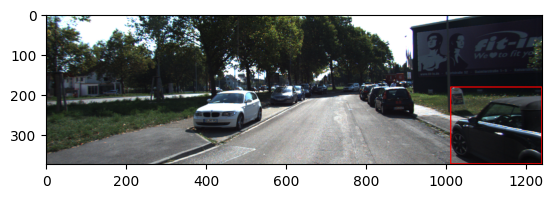

In [48]:
print(kitti_dataset[10])

img = np.asanyarray(kitti_dataset[10][0].copy())
print(img.shape)
cv2.rectangle(img,(int(kitti_dataset[10][1][0]['bbox'][0]),int(kitti_dataset[10][1][0]['bbox'][1])),(int(kitti_dataset[10][1][0]['bbox'][2]),int(kitti_dataset[10][1][0]['bbox'][3])),(255,0,0),2)
plt.imshow(img)

In [49]:
labels = set()
for img, targets in kitti_dataset:
    for target in targets:
        labels.add(target['type'])

print(labels)

{'Car', 'Pedestrian', 'DontCare', 'Truck', 'Tram', 'Cyclist', 'Person_sitting', 'Misc', 'Van'}


In [52]:
labels_dir = os.path.normpath('./datasets/Kitti/raw/training/label_2/')
new_labels = os.path.normpath('datasets/Kitti/raw/training/labels_new')
img_shape = (375, 1242)

if not os.path.exists(new_labels):
    os.mkdir(new_labels)

reverse_labels_dict = {0: 'Pedestrian',
                       1: 'Cyclist',
                       2: 'Car'}
labels_dict = { 'Pedestrian': 0,
               'Cyclist': 1,
               'Car': 2}


In [36]:
def select_elements(list_, elements):
    return [list_[e] for e in elements]

In [53]:
for file_ in os.listdir(labels_dir):
    tmp_path = os.path.join(labels_dir, file_)
    new_file = os.path.join(new_labels, file_)
    new_lines = []

    # Read the data from the labels files
    with open(tmp_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(' ')
            elements = [line[e] for e in [0, 4, 5, 6, 7]]

            # Normalize bbox coordinates
            x = (float(elements[1]) + float(elements[3])) / (2 * img_shape[1])
            y = (float(elements[2]) + float(elements[4])) / (2 * img_shape[0])
            w = (float(elements[3]) - float(elements[1])) / img_shape[1]
            h = (float(elements[4]) - float(elements[2])) / img_shape[0]
            
            elements[1] = x
            elements[2] = y
            elements[3] = w
            elements[4] = h

            # Translate type to numbers and convert types of cars and people to standard
            type_ = elements[0]
            if type_ in ['Pedestrian', 'Person_sitting']:
                elements[0] = labels_dict['Pedestrian']
            elif type_ == 'Cyclist':
                elements[0] = labels_dict['Cyclist']
            elif type_ in ['Van', 'Truck', 'Car']:
                elements[0] = labels_dict['Car']

            # Add the translated elements for the new file                
            if elements[0] in labels_dict.values():
                elements = list(map(str, elements))
                tmp_line = ' '.join(elements)
                new_lines.append(tmp_line)

    # Write the new translated classes to the new file
    with open(new_file, 'w') as f:
        for line in new_lines:
            f.write(f'{line}\n')

In [35]:
img_path = os.path.normpath('raw_videos/seq_01/image_02/data/')
labels_path = os.path.normpath('raw_videos/seq_01/labels.txt')
path_cam_params = os.path.normpath('raw_videos/calib_cam_to_cam.txt')
val_path_image = os.path.normpath('datasets/custom/val/image_2')
val_path_label = os.path.normpath('datasets/custom/val/label_2')

if not os.path.exists(val_path_image):
    os.mkdir(val_path_image)
if not os.path.exists(val_path_label):
    os.mkdir(val_path_label)


In [36]:
df_temp = pd.read_csv(labels_path, sep=' ', header=None)
df_labels = pd.DataFrame(data={
    'frame': df_temp[0],
    'id': df_temp[1],
    'label': df_temp[2],
    'truncated': df_temp[3],
    'occluded': df_temp[4],
    'alpha': df_temp[5],
    'bbox': list(df_temp[list(range(6, 10))].values),
    'dimensions': df_temp[list(range(10, 13))].values.tolist(),
    'location': df_temp[list(range(13, 16))].values.tolist(),
    'rotation_y': df_temp[16],
    # 'score': df_temp[16],
})
df_labels.head()

,frame,id,label,truncated,occluded,alpha,bbox,dimensions,location,rotation_y
0,0,0,Pedestrian,0,1,0.727451,"[466.194319, 139.161762, 557.19432, 332.842544]","[1.744482, 0.520582, 0.834498]","[-0.875495, 1.374252, 6.816363]",0.607547
1,0,1,Pedestrian,0,0,0.612450,"[389.158096, 150.885617, 497.158096, 359.917155]","[1.625074, 0.630655, 0.721248]","[-1.333895, 1.397117, 5.92395]",0.404248
2,0,5,Pedestrian,0,1,1.321152,"[485.398585, 145.273299, 502.065252, 200.312156]","[1.677151, 0.446023, 0.749989]","[-3.436733, 0.602339, 21.976265]",1.170425
3,0,6,Pedestrian,0,1,1.662855,"[525.723004, 137.996529, 541.38967, 191.857804]","[1.952553, 0.628458, 0.744739]","[-2.640812, 0.409017, 26.109648]",1.565453
4,0,7,Pedestrian,0,0,1.589458,"[545.146393, 143.123321, 559.813059, 190.469783]","[1.709764, 0.597256, 0.524796]","[-1.905936, 0.357788, 25.902194]",1.519108


In [5]:
left_cam_params, right_cam_params = load_cam_parameters(path_cam_params, camera_left=2, camera_right=3)

In [37]:
df_labels['label'] = df_labels['label'].replace(labels_dict)
df_labels.head()

,frame,id,label,truncated,occluded,alpha,bbox,dimensions,location,rotation_y
0,0,0,0,0,1,0.727451,"[466.194319, 139.161762, 557.19432, 332.842544]","[1.744482, 0.520582, 0.834498]","[-0.875495, 1.374252, 6.816363]",0.607547
1,0,1,0,0,0,0.612450,"[389.158096, 150.885617, 497.158096, 359.917155]","[1.625074, 0.630655, 0.721248]","[-1.333895, 1.397117, 5.92395]",0.404248
2,0,5,0,0,1,1.321152,"[485.398585, 145.273299, 502.065252, 200.312156]","[1.677151, 0.446023, 0.749989]","[-3.436733, 0.602339, 21.976265]",1.170425
3,0,6,0,0,1,1.662855,"[525.723004, 137.996529, 541.38967, 191.857804]","[1.952553, 0.628458, 0.744739]","[-2.640812, 0.409017, 26.109648]",1.565453
4,0,7,0,0,0,1.589458,"[545.146393, 143.123321, 559.813059, 190.469783]","[1.709764, 0.597256, 0.524796]","[-1.905936, 0.357788, 25.902194]",1.519108


In [7]:
print(left_cam_params)

{'size': array([1392,  512]), 'K': array([[956.9475,   0.    , 693.9767],
       [  0.    , 952.2352, 238.6081],
       [  0.    ,   0.    ,   1.    ]]), 'D': array([-0.3750956 ,  0.2076838 ,  0.00043485,  0.00160316, -0.07469243]), 'R': array([[ 0.9999838 , -0.00501274, -0.00271074],
       [ 0.00500201,  0.9999797 , -0.00395038],
       [ 0.00273049,  0.00393676,  0.9999885 ]]), 'T': array([[ 0.05989688],
       [-0.00136783],
       [ 0.00463762]]), 'size_rect': array([1224,  370]), 'R_rect': array([[ 9.998691e-01,  1.512763e-02, -5.741851e-03],
       [-1.512861e-02,  9.998855e-01, -1.287536e-04],
       [ 5.739247e-03,  2.156030e-04,  9.999835e-01]]), 'P_rect': array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02,  4.575831e+01],
       [ 0.000000e+00,  7.070493e+02,  1.805066e+02, -3.454157e-01],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  4.981016e-03]])}


## Loop to save rectified images and labels

In [38]:
for idx, img_file in enumerate(os.listdir(img_path)):
    
    path_to_file = os.path.join(img_path, img_file)
    img_save_path = os.path.join(val_path_image, img_file)
    label_save_path = os.path.join(val_path_label, img_file.split('.')[0] + '.txt')

    # Block to rectify and save image into custom dataset
    img_bgr = cv2.imread(path_to_file)
    height, width = img_bgr.shape[:2]
    # img_rectified = rectify_frame(img_bgr, left_cam_params)
    cv2.imwrite(img_save_path, img_bgr)

    # Block to save image labels into custom dataset
    img_labels = df_labels[df_labels['frame'] == idx].copy()
    img_labels = img_labels[['label', 'bbox']]
    x_col, y_col, w_col, h_col = [], [], [], []
    for i, (x, y, w, h) in enumerate(img_labels['bbox']):
        x_norm = ((w + x) / 2) / width
        w_norm = (w - x) / width
        y_norm = ((h + y) / 2) / height
        h_norm = (h - y) / height

        x_col.append(x_norm)
        y_col.append(y_norm)
        w_col.append(w_norm)
        h_col.append(h_norm)
        # img_labels['bbox'].iloc[i] = '{} {} {} {}'.format(x_norm, y_norm, w_norm, h_norm)
    
    img_labels = img_labels.assign(x_norm = x_col,
                                                y_norm = y_col,
                                                w_norm = w_col,
                                                h_norm = h_col) 
    img_labels.drop('bbox', axis=1, inplace=True)
    img_labels.to_csv(label_save_path, sep=' ', header=False, index=False)


In [32]:
img = cv2.imread('datasets/custom/val/image_2/20000000005.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
labels = pd.read_csv('datasets/custom/val/label_2/20000000005.txt', sep=' ', header=None)
labels.head()

,0,1,2,3,4
0,2,0.947333,0.570435,0.103700,0.138940
1,2,0.894444,0.562643,0.102631,0.131824
2,2,0.825667,0.562712,0.094772,0.142059
3,2,0.506260,0.506963,0.027953,0.081945
4,1,0.210453,0.729451,0.140353,0.535693


In [24]:
HEIGHT, WIDTH = img.shape[:2]
WIDTH, HEIGHT

(1224, 370)

In [33]:
x = int(labels.iloc[0, 1]*WIDTH)
y = int(labels.iloc[0, 2]*HEIGHT)
w = int(labels.iloc[0, 3]*WIDTH) / 2
h = int(labels.iloc[0, 4]*HEIGHT) / 2

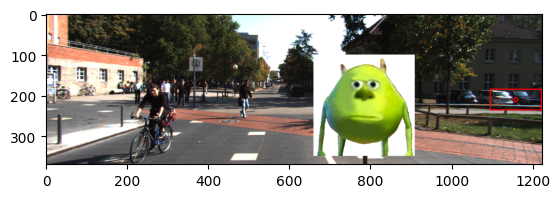

In [34]:
cv2.rectangle(img_rgb, (int(x - w),  int(y - h)), (int(x + w), int(y+h)), (255, 0, 0), 2)
cv2.circle(img_rgb, (x, y), 5, (255, 0, 0), 2)
plt.imshow(img_rgb)
plt.show()